# Convolutional neural networks

In [1]:
import pickle
import numpy as np
import keras
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In class, we have briefly reviewed the idea of learning good features directly from data and went through the concept of convolutional neural networks along with few architectures.

Until recently, building convolutional neural networks was tough. There was no high-level tools for that, you would be required to understand all the internal mechanics of the model and its operations.

Today, due to the high-level tools such as Keras and TensorFlow, everybody can build a convolutional neural network and put it to work without diving deep into them. What used to be a one-month project became a few hours exercise.


## Loading the images

In [0]:
train_images, train_labels = pickle.load(open('/data/train_set_all.pkl', 'rb'))
cv_images, cv_labels = pickle.load(open('/data/test_set_all.pkl', 'rb'))

In [6]:
print(train_images.shape)
print(len(train_labels))

(50000, 32, 32, 3)
50000


In [7]:
print(cv_images.shape)
print(len(cv_labels))

(10000, 32, 32, 3)
10000


In [8]:
print(train_labels[0:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [0]:
# convert train labels to one hot encoing 
num_classes = 10

train_labels = keras.utils.to_categorical(train_labels, num_classes)
cv_labels = keras.utils.to_categorical(cv_labels, num_classes)

In [10]:
print(train_labels[0:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [0]:
def show_image(np_array):
    %matplotlib inline
    plt.figure()
    plt.imshow(np_array)

In [0]:
def show_example(data_set, labels, example_index):
    show_image(data_set[example_index])
    print('Label: ', labels[example_index])

Label:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


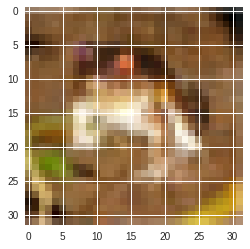

In [13]:
show_example(train_images, train_labels, example_index = 0)

Label:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


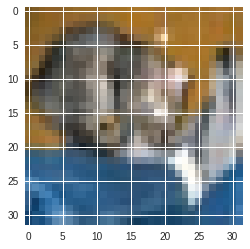

In [14]:
show_example(cv_images, cv_labels, example_index = 0)

## Building AlexNet

In 2012 a convolutional neural network called AlexNet won ImageNet competition. 

Go through an [original AlexNet paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) to investigate the architecture. Next, investigate the [basics of Keras](https://keras.io/#keras-the-python-deep-learning-library). We will use it with TensorFlow backend.

You are also encouraged to go through some CNN tutorial for Keras. There is a number of them online (for example, [this](https://elitedatascience.com/keras-tutorial-deep-learning-in-python) or [this](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)).
Now, build AlexNex network with Keras for object recognition. Note that standard AlexNet works with 224x224 input images. The dataset you are going to use for this problem is 32x32.

In [0]:
# characteristics of Cifar-10 data
img_height, img_width, channel = train_images.shape[1],train_images.shape[2],train_images.shape[3]

In [0]:
from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

np.random.seed(123)  # for reproducibility

I wanted to create as close architecture to the original Alexnet as possible for one path strategy. But taking into account the difference in size of input data (32x32 pixels instead of 244x244) I introduced the next changes:  

1) as the picture on input is much smaller the receptive field of size 11x11 and stride 4x4 for the first CONV layer are too large. So I decided to use RF of size 3x3 and stride 2x2

2) I used standart BatchNormalization layer from Keras instead of a special normalization which authors provide in paper - Local Responce Normalization

3) In original paper they only remove mean pixel activity of train dataset for each of RGB channels for both train and test data sets. But I performed also data standartization because this improved the speed of training and model performance.

In [0]:
# data normalization
# creation of new variables to have an opportunity to go back to initial data

x_train = train_images.astype('float32')
x_test = cv_images.astype('float32')

# calculating mean and std channel (RGB) - wise for all the train data set
mean = np.mean(x_train,axis=(0,1,2)) 
std = np.std(x_train,axis=(0,1,2))
x_train -=mean
x_test -= mean

In [0]:
# define the model
delimiter = 1 # I was experimenting with number of filters but reducing their number proportionally leaded to lower accuracy,
              # so I remained original number of filters (as in the paper)

model = Sequential()

model.add(Conv2D(96//delimiter, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256//delimiter, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(BatchNormalization())
 
model.add(Conv2D(384//delimiter, (3,3), activation='relu', padding='same'))
model.add(Conv2D(384//delimiter, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256//delimiter, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096//delimiter//delimiter, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(4096//delimiter//delimiter, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [19]:
# print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 96)        2688      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 96)          384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 3, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 384)         885120    
__________

## Training AlexNet

Use training set for training the network to recognize objects. You might want to use RMSProp optimizer to speed up the training.

Convolutional networks require a lot of computing power for training. Typical setup for training CNN is to use GPU, however, in this problem you are not required to do so. CPU will be fine as well.

If you are using CPU for this subproblem, training process might be slow. You can stop it manually as soon as you get meaningful results.

Report the results on the training and cross-validation sets. The report should contain the training logs.

In [0]:
# determine optimizer - I tried different options and decided to use RMSProp for this part
sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
adam = keras.optimizers.Adam()

In [0]:
# compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = rmsprop , 
              metrics = ['accuracy'])

# checkpoint setting
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
# Setting parameters for training

batch_size = 64 # in original paper they used batch size of 128 but pictures and data set were bigger and they used GPU. 
                # I decided to use 64 as batch size and also trained on GPU
epochs = 50


In [0]:
# Train the Model
start = time.time()

model_info = model.fit(x_train, train_labels,
                          batch_size = batch_size,
                          epochs = epochs,
                          verbose = 1,
                          callbacks=callbacks_list
                          ,validation_data = (x_test, cv_labels)
                      )
end = time.time()


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
44160/50000 [=========================>....] - ETA: 5s - loss: 1.1259 - acc: 0.6156

50000/50000 [==============================] - 48s 956us/step - loss: 1.1165 - acc: 0.6188 - val_loss: 1.2575 - val_acc: 0.6116

Epoch 00001: val_acc improved from 0.54840 to 0.61160, saving model to weights-improvement-01-0.61.hdf5
Epoch 2/50
17920/50000 [=========>....................] - ETA: 29s - loss: 0.8766 - acc: 0.7044

50000/50000 [==============================] - 48s 966us/step - loss: 0.8774 - acc: 0.7029 - val_loss: 0.9765 - val_acc: 0.6718

Epoch 00002: val_acc improved from 0.61160 to 0.67180, saving model to weights-improvement-02-0.67.hdf5
Epoch 3/50
11136/50000 [=====>........................] - ETA: 36s - loss: 0.6686 - acc: 0.7723

50000/50000 [==============================] - 48s 968us/step - loss: 0.6985 - acc: 0.7618 - val_loss: 1.0651 - val_acc: 0.6650

Epoch 00003: val_acc did not improve
Epoch 4/50
11968/50000 [======>.......................] - ETA: 35s - loss: 0.5170 - acc: 0.8234

50000/50000 [==============================] - 48s 968us/step - loss: 0.5474 - acc: 0.8124 - val_loss: 1.0331 - val_acc: 0.6883

Epoch 00004: val_acc improved from 0.67180 to 0.68830, saving model to weights-improvement-04-0.69.hdf5
Epoch 5/50
 9664/50000 [====>.........................] - ETA: 37s - loss: 0.3783 - acc: 0.8696

50000/50000 [==============================] - 48s 967us/step - loss: 0.4238 - acc: 0.8559 - val_loss: 1.0652 - val_acc: 0.7004

Epoch 00005: val_acc improved from 0.68830 to 0.70040, saving model to weights-improvement-05-0.70.hdf5
Epoch 6/50
 9088/50000 [====>.........................] - ETA: 37s - loss: 0.2840 - acc: 0.9015

50000/50000 [==============================] - 48s 958us/step - loss: 0.3255 - acc: 0.8879 - val_loss: 1.0115 - val_acc: 0.7312

Epoch 00006: val_acc improved from 0.70040 to 0.73120, saving model to weights-improvement-06-0.73.hdf5
Epoch 7/50
 8960/50000 [====>.........................] - ETA: 38s - loss: 0.2308 - acc: 0.9277

50000/50000 [==============================] - 48s 957us/step - loss: 0.2588 - acc: 0.9133 - val_loss: 1.3251 - val_acc: 0.7025

Epoch 00007: val_acc did not improve
Epoch 8/50
11264/50000 [=====>........................] - ETA: 35s - loss: 0.1829 - acc: 0.9399

50000/50000 [==============================] - 48s 966us/step - loss: 0.2121 - acc: 0.9282 - val_loss: 1.2345 - val_acc: 0.7192

Epoch 00008: val_acc did not improve
Epoch 9/50
12032/50000 [======>.......................] - ETA: 35s - loss: 0.1530 - acc: 0.9461

50000/50000 [==============================] - 48s 959us/step - loss: 0.1807 - acc: 0.9382 - val_loss: 1.3804 - val_acc: 0.7144

Epoch 00009: val_acc did not improve
Epoch 10/50
12224/50000 [======>.......................] - ETA: 34s - loss: 0.1446 - acc: 0.9492

50000/50000 [==============================] - 48s 952us/step - loss: 0.1600 - acc: 0.9449 - val_loss: 1.5064 - val_acc: 0.7126

Epoch 00010: val_acc did not improve
Epoch 11/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.1216 - acc: 0.9583

50000/50000 [==============================] - 48s 957us/step - loss: 0.1418 - acc: 0.9522 - val_loss: 1.5240 - val_acc: 0.7100

Epoch 00011: val_acc did not improve
Epoch 12/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.1138 - acc: 0.9619

50000/50000 [==============================] - 48s 955us/step - loss: 0.1257 - acc: 0.9576 - val_loss: 1.5081 - val_acc: 0.7208

Epoch 00012: val_acc did not improve
Epoch 13/50
12288/50000 [======>.......................] - ETA: 35s - loss: 0.1123 - acc: 0.9629

50000/50000 [==============================] - 48s 958us/step - loss: 0.1150 - acc: 0.9611 - val_loss: 1.5135 - val_acc: 0.7206

Epoch 00013: val_acc did not improve
Epoch 14/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0917 - acc: 0.9697

50000/50000 [==============================] - 48s 962us/step - loss: 0.1064 - acc: 0.9646 - val_loss: 1.4634 - val_acc: 0.7316

Epoch 00014: val_acc improved from 0.73120 to 0.73160, saving model to weights-improvement-14-0.73.hdf5
Epoch 15/50
 9728/50000 [====>.........................] - ETA: 37s - loss: 0.0891 - acc: 0.9679

50000/50000 [==============================] - 48s 966us/step - loss: 0.0991 - acc: 0.9664 - val_loss: 1.5164 - val_acc: 0.7310

Epoch 00015: val_acc did not improve
Epoch 16/50
11456/50000 [=====>........................] - ETA: 35s - loss: 0.0834 - acc: 0.9727

50000/50000 [==============================] - 48s 964us/step - loss: 0.0929 - acc: 0.9693 - val_loss: 1.5524 - val_acc: 0.7233

Epoch 00016: val_acc did not improve
Epoch 17/50
12032/50000 [======>.......................] - ETA: 35s - loss: 0.0748 - acc: 0.9752

50000/50000 [==============================] - 48s 967us/step - loss: 0.0860 - acc: 0.9719 - val_loss: 1.5893 - val_acc: 0.7245

Epoch 00017: val_acc did not improve
Epoch 18/50
12224/50000 [======>.......................] - ETA: 35s - loss: 0.0763 - acc: 0.9739

50000/50000 [==============================] - 48s 967us/step - loss: 0.0821 - acc: 0.9723 - val_loss: 1.6146 - val_acc: 0.7277

Epoch 00018: val_acc did not improve
Epoch 19/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0677 - acc: 0.9770

50000/50000 [==============================] - 48s 965us/step - loss: 0.0768 - acc: 0.9751 - val_loss: 1.6250 - val_acc: 0.7259

Epoch 00019: val_acc did not improve
Epoch 20/50
12288/50000 [======>.......................] - ETA: 35s - loss: 0.0629 - acc: 0.9794

50000/50000 [==============================] - 48s 961us/step - loss: 0.0727 - acc: 0.9753 - val_loss: 1.6484 - val_acc: 0.7254

Epoch 00020: val_acc did not improve
Epoch 21/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0565 - acc: 0.9824

50000/50000 [==============================] - 48s 955us/step - loss: 0.0655 - acc: 0.9792 - val_loss: 1.5931 - val_acc: 0.7439

Epoch 00021: val_acc improved from 0.73160 to 0.74390, saving model to weights-improvement-21-0.74.hdf5
Epoch 22/50
 9728/50000 [====>.........................] - ETA: 37s - loss: 0.0582 - acc: 0.9810

50000/50000 [==============================] - 48s 953us/step - loss: 0.0650 - acc: 0.9784 - val_loss: 1.6104 - val_acc: 0.7378

Epoch 00022: val_acc did not improve
Epoch 23/50
11456/50000 [=====>........................] - ETA: 35s - loss: 0.0599 - acc: 0.9817

50000/50000 [==============================] - 48s 956us/step - loss: 0.0644 - acc: 0.9795 - val_loss: 1.6037 - val_acc: 0.7312

Epoch 00023: val_acc did not improve
Epoch 24/50
12032/50000 [======>.......................] - ETA: 34s - loss: 0.0538 - acc: 0.9836

50000/50000 [==============================] - 48s 962us/step - loss: 0.0591 - acc: 0.9812 - val_loss: 1.5986 - val_acc: 0.7358

Epoch 00024: val_acc did not improve
Epoch 25/50
12224/50000 [======>.......................] - ETA: 35s - loss: 0.0521 - acc: 0.9829

50000/50000 [==============================] - 48s 967us/step - loss: 0.0575 - acc: 0.9809 - val_loss: 1.6811 - val_acc: 0.7294

Epoch 00025: val_acc did not improve
Epoch 26/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0497 - acc: 0.9836

50000/50000 [==============================] - 48s 958us/step - loss: 0.0557 - acc: 0.9819 - val_loss: 1.7584 - val_acc: 0.7251

Epoch 00026: val_acc did not improve
Epoch 27/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0467 - acc: 0.9850

50000/50000 [==============================] - 48s 963us/step - loss: 0.0544 - acc: 0.9824 - val_loss: 1.7197 - val_acc: 0.7298

Epoch 00027: val_acc did not improve
Epoch 28/50
12288/50000 [======>.......................] - ETA: 35s - loss: 0.0400 - acc: 0.9867

50000/50000 [==============================] - 49s 970us/step - loss: 0.0492 - acc: 0.9840 - val_loss: 1.7226 - val_acc: 0.7374

Epoch 00028: val_acc did not improve
Epoch 29/50
12288/50000 [======>.......................] - ETA: 35s - loss: 0.0446 - acc: 0.9839

50000/50000 [==============================] - 48s 967us/step - loss: 0.0486 - acc: 0.9843 - val_loss: 1.7678 - val_acc: 0.7346

Epoch 00029: val_acc did not improve
Epoch 30/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0461 - acc: 0.9849

50000/50000 [==============================] - 48s 960us/step - loss: 0.0506 - acc: 0.9835 - val_loss: 1.6580 - val_acc: 0.7341

Epoch 00030: val_acc did not improve
Epoch 31/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0377 - acc: 0.9874

50000/50000 [==============================] - 48s 958us/step - loss: 0.0455 - acc: 0.9856 - val_loss: 1.6939 - val_acc: 0.7441

Epoch 00031: val_acc improved from 0.74390 to 0.74410, saving model to weights-improvement-31-0.74.hdf5
Epoch 32/50
 9728/50000 [====>.........................] - ETA: 37s - loss: 0.0421 - acc: 0.9878

50000/50000 [==============================] - 48s 959us/step - loss: 0.0454 - acc: 0.9862 - val_loss: 1.7139 - val_acc: 0.7370

Epoch 00032: val_acc did not improve
Epoch 33/50
11456/50000 [=====>........................] - ETA: 35s - loss: 0.0395 - acc: 0.9872

50000/50000 [==============================] - 48s 968us/step - loss: 0.0440 - acc: 0.9858 - val_loss: 1.7284 - val_acc: 0.7359

Epoch 00033: val_acc did not improve
Epoch 34/50
12032/50000 [======>.......................] - ETA: 35s - loss: 0.0403 - acc: 0.9864

50000/50000 [==============================] - 48s 969us/step - loss: 0.0424 - acc: 0.9863 - val_loss: 1.7050 - val_acc: 0.7419

Epoch 00034: val_acc did not improve
Epoch 35/50
12224/50000 [======>.......................] - ETA: 35s - loss: 0.0408 - acc: 0.9870

50000/50000 [==============================] - 48s 965us/step - loss: 0.0452 - acc: 0.9857 - val_loss: 1.7075 - val_acc: 0.7394

Epoch 00035: val_acc did not improve
Epoch 36/50
12288/50000 [======>.......................] - ETA: 35s - loss: 0.0365 - acc: 0.9881

50000/50000 [==============================] - 48s 961us/step - loss: 0.0393 - acc: 0.9873 - val_loss: 1.7740 - val_acc: 0.7410

Epoch 00036: val_acc did not improve
Epoch 37/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0356 - acc: 0.9893

50000/50000 [==============================] - 48s 956us/step - loss: 0.0382 - acc: 0.9884 - val_loss: 1.8600 - val_acc: 0.7337

Epoch 00037: val_acc did not improve
Epoch 38/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0350 - acc: 0.9877

50000/50000 [==============================] - 48s 961us/step - loss: 0.0395 - acc: 0.9876 - val_loss: 1.8680 - val_acc: 0.7308

Epoch 00038: val_acc did not improve
Epoch 39/50
12288/50000 [======>.......................] - ETA: 34s - loss: 0.0333 - acc: 0.9886

50000/50000 [==============================] - 48s 963us/step - loss: 0.0369 - acc: 0.9881 - val_loss: 1.7851 - val_acc: 0.7489

Epoch 00039: val_acc improved from 0.74410 to 0.74890, saving model to weights-improvement-39-0.75.hdf5
Epoch 40/50
 9728/50000 [====>.........................] - ETA: 37s - loss: 0.0335 - acc: 0.9884

50000/50000 [==============================] - 48s 963us/step - loss: 0.0381 - acc: 0.9880 - val_loss: 1.7608 - val_acc: 0.7413

Epoch 00040: val_acc did not improve
Epoch 41/50
11456/50000 [=====>........................] - ETA: 36s - loss: 0.0318 - acc: 0.9907

50000/50000 [==============================] - 48s 970us/step - loss: 0.0368 - acc: 0.9888 - val_loss: 1.8225 - val_acc: 0.7329

Epoch 00041: val_acc did not improve
Epoch 42/50
12032/50000 [======>.......................] - ETA: 35s - loss: 0.0315 - acc: 0.9901

50000/50000 [==============================] - 48s 965us/step - loss: 0.0337 - acc: 0.9895 - val_loss: 1.9743 - val_acc: 0.7364

Epoch 00042: val_acc did not improve
Epoch 43/50
12224/50000 [======>.......................] - ETA: 34s - loss: 0.0332 - acc: 0.9902

40896/50000 [=======================>......] - ETA: 8s - loss: 0.0339 - acc: 0.9896

In [0]:
def plot_model_history(model_history):
  # plots accuracy and loss
  
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Plot results of fitting original Alexnet architecture for CIFAR-10

In [0]:
def load_trained_model(model, weights_path):
  # loads weights for a model with defined architecture 
   
    model.load_weights(weights_path)

The weights for pretrained original Alexnet architecture for CIFAR-10 dataset can be found here: [Original Alexnet for CIFAR-10 weights](https://drive.google.com/open?id=1gKDfvI2nGD2RoD1hVlV_dxmeNuyO2P5y)

To load weights in this notebook download the .hdf5 in the same location with this notebook.

In [0]:
# to load model from file change load_trained to True
load_trained = False

if load_trained:
    model = load_trained_model(model, 'original-weights.hdf5')
    score = model.evaluate(x_test, cv_labels, verbose=0)
    print('Loss on test data is:', score[0])
    print('Accuracy on test data is:', score[1]*100)

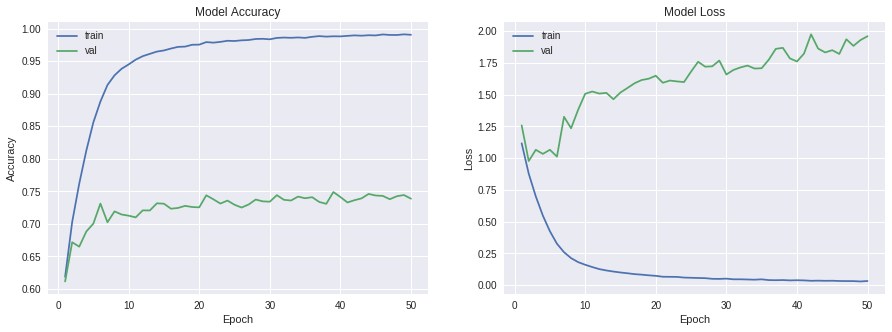

Model took 2401.90 seconds to train
Loss on test data is: 1.9595486815929413
Accuracy on test data is: 73.87


In [30]:
# plot model history
plot_model_history(model_info)
print ("Model took %0.2f seconds to train"%(end - start))

score = model.evaluate(x_test, cv_labels, verbose=0)
print('Loss on test data is:', score[0])
print('Accuracy on test data is:', score[1]*100)

As we can see from the graphs, my loss started to grow on validation set after 6th epoch. This means overfitting.
So in improved Alexnet I will try to overcome overfitting.

## Improving AlexNet

As you can see, AlexNet does not work very well on such a small dataset. Recall what you have learned from this class to improve its performance. You can also take a look at the [Dropout technique](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) and its [implementation in Keras](https://keras.io/layers/core/#dropout). 

In the improved model the changes I made:

1) used data sugmentation

2) changed number of filters as it seemed to mee that the original achitecture has too muchh filters on each layer as for imput picture size of 32x32

3) changed Maxpooling sizes and strides

4) added a convolutional layer so that now I have 2*CONV+Normalization+Maxpooling+dropout 3 times and then 3 fully connected layers

5) used regularizer for CONV layers

In [0]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train)


In [45]:
# define improved model
filters_number = 32
weight_decay = 1e-4
regularizer = keras.regularizers.l2(weight_decay)

model_improved = Sequential()

model_improved.add(Conv2D(filters_number, (3,3), activation = 'relu', padding='same',kernel_regularizer=regularizer, input_shape=(img_height, img_width, channel,)))
model_improved.add(BatchNormalization())
model_improved.add(Conv2D(filters_number, (3,3), activation = 'relu', padding='same', kernel_regularizer=regularizer))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D(pool_size=(2,2)))
model_improved.add(Dropout(0.2))

model_improved.add(Conv2D(2*filters_number, (3,3), activation = 'relu', padding='same', kernel_regularizer=regularizer))
model_improved.add(BatchNormalization())
model_improved.add(Conv2D(2*filters_number, (3,3), activation = 'relu', padding='same', kernel_regularizer=regularizer))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D(pool_size=(2,2)))
model_improved.add(Dropout(0.3))

model_improved.add(Conv2D(4*filters_number, (3,3), activation = 'relu', padding='same', kernel_regularizer=regularizer))
model_improved.add(BatchNormalization())
model_improved.add(Conv2D(4*filters_number, (3,3), activation = 'relu', padding='same', kernel_regularizer=regularizer))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D(pool_size=(2,2)))
model_improved.add(Dropout(0.4))

model_improved.add(Flatten())
model_improved.add(Dense(8*filters_number, activation='tanh'))
model_improved.add(Dropout(0.5))
model_improved.add(Dense(8*filters_number, activation='tanh'))
model_improved.add(Dropout(0.5))
model_improved.add(Dense(num_classes, activation='softmax'))

model_improved.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
__________

### Train the improved model

In [46]:
# setting parameters 
batch_size = 64
epochs = 50

#compiling model
model_improved.compile(loss='categorical_crossentropy',
        optimizer=rmsprop,
        metrics=['accuracy'])

# checkpoint setting
filepath="improved-model-weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc',
                                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# train the improved model
start = time.time()

improved_model_history = model_improved.fit_generator(
                             datagen.flow(x_train, train_labels, batch_size=batch_size),
                             steps_per_epoch=x_train.shape[0] // batch_size, 
                             epochs=epochs,
                             verbose = 1, 
                             callbacks = callbacks_list,
                             validation_data=(x_test, cv_labels))
end = time.time()

Epoch 1/50
781/781 [==============================] - 76s 97ms/step - loss: 2.3854 - acc: 0.2283 - val_loss: 1.6967 - val_acc: 0.4190

Epoch 00001: val_acc improved from -inf to 0.41900, saving model to improved-model-weights-01-0.42.hdf5
Epoch 2/50
 84/781 [==>...........................] - ETA: 56s - loss: 2.0847 - acc: 0.2972

781/781 [==============================] - 72s 92ms/step - loss: 1.9808 - acc: 0.3224 - val_loss: 1.5635 - val_acc: 0.4692

Epoch 00002: val_acc improved from 0.41900 to 0.46920, saving model to improved-model-weights-02-0.47.hdf5
Epoch 3/50
134/781 [====>.........................] - ETA: 53s - loss: 1.8651 - acc: 0.3552

781/781 [==============================] - 72s 93ms/step - loss: 1.8060 - acc: 0.3723 - val_loss: 1.5411 - val_acc: 0.4901

Epoch 00003: val_acc improved from 0.46920 to 0.49010, saving model to improved-model-weights-03-0.49.hdf5
Epoch 4/50
143/781 [====>.........................] - ETA: 57s - loss: 1.7143 - acc: 0.3915

781/781 [==============================] - 72s 92ms/step - loss: 1.6805 - acc: 0.4105 - val_loss: 1.5723 - val_acc: 0.4952

Epoch 00004: val_acc improved from 0.49010 to 0.49520, saving model to improved-model-weights-04-0.50.hdf5
Epoch 5/50
147/781 [====>.........................] - ETA: 54s - loss: 1.6225 - acc: 0.4463

781/781 [==============================] - 71s 90ms/step - loss: 1.5796 - acc: 0.4495 - val_loss: 1.4921 - val_acc: 0.5191

Epoch 00005: val_acc improved from 0.49520 to 0.51910, saving model to improved-model-weights-05-0.52.hdf5
Epoch 6/50
154/781 [====>.........................] - ETA: 50s - loss: 1.5228 - acc: 0.4631

781/781 [==============================] - 71s 91ms/step - loss: 1.4993 - acc: 0.4756 - val_loss: 1.4508 - val_acc: 0.5384

Epoch 00006: val_acc improved from 0.51910 to 0.53840, saving model to improved-model-weights-06-0.54.hdf5
Epoch 7/50
153/781 [====>.........................] - ETA: 52s - loss: 1.4486 - acc: 0.4964

781/781 [==============================] - 72s 92ms/step - loss: 1.4170 - acc: 0.5090 - val_loss: 1.4750 - val_acc: 0.5393

Epoch 00007: val_acc improved from 0.53840 to 0.53930, saving model to improved-model-weights-07-0.54.hdf5
Epoch 8/50
150/781 [====>.........................] - ETA: 52s - loss: 1.4013 - acc: 0.5109

781/781 [==============================] - 71s 91ms/step - loss: 1.3550 - acc: 0.5299 - val_loss: 1.3509 - val_acc: 0.5755

Epoch 00008: val_acc improved from 0.53930 to 0.57550, saving model to improved-model-weights-08-0.58.hdf5
Epoch 9/50
149/781 [====>.........................] - ETA: 56s - loss: 1.3062 - acc: 0.5462

781/781 [==============================] - 72s 92ms/step - loss: 1.2957 - acc: 0.5522 - val_loss: 1.2184 - val_acc: 0.6035

Epoch 00009: val_acc improved from 0.57550 to 0.60350, saving model to improved-model-weights-09-0.60.hdf5
Epoch 10/50
152/781 [====>.........................] - ETA: 52s - loss: 1.2582 - acc: 0.5644

781/781 [==============================] - 71s 91ms/step - loss: 1.2488 - acc: 0.5714 - val_loss: 1.2526 - val_acc: 0.6035

Epoch 00010: val_acc did not improve
Epoch 11/50
193/781 [======>.......................] - ETA: 48s - loss: 1.2132 - acc: 0.5841

781/781 [==============================] - 69s 89ms/step - loss: 1.2007 - acc: 0.5906 - val_loss: 1.3067 - val_acc: 0.5959

Epoch 00011: val_acc did not improve
Epoch 12/50
205/781 [======>.......................] - ETA: 49s - loss: 1.1968 - acc: 0.5924

781/781 [==============================] - 72s 93ms/step - loss: 1.1665 - acc: 0.6022 - val_loss: 1.1868 - val_acc: 0.6328

Epoch 00012: val_acc improved from 0.60350 to 0.63280, saving model to improved-model-weights-12-0.63.hdf5
Epoch 13/50
164/781 [=====>........................] - ETA: 56s - loss: 1.1412 - acc: 0.6107

781/781 [==============================] - 72s 92ms/step - loss: 1.1304 - acc: 0.6157 - val_loss: 1.1412 - val_acc: 0.6436

Epoch 00013: val_acc improved from 0.63280 to 0.64360, saving model to improved-model-weights-13-0.64.hdf5
Epoch 14/50
151/781 [====>.........................] - ETA: 54s - loss: 1.1329 - acc: 0.6183

781/781 [==============================] - 73s 93ms/step - loss: 1.0989 - acc: 0.6280 - val_loss: 1.2103 - val_acc: 0.6273

Epoch 00014: val_acc did not improve
Epoch 15/50
196/781 [======>.......................] - ETA: 50s - loss: 1.0821 - acc: 0.6308

781/781 [==============================] - 72s 92ms/step - loss: 1.0669 - acc: 0.6429 - val_loss: 1.0672 - val_acc: 0.6669

Epoch 00015: val_acc improved from 0.64360 to 0.66690, saving model to improved-model-weights-15-0.67.hdf5
Epoch 16/50
168/781 [=====>........................] - ETA: 53s - loss: 1.0571 - acc: 0.6484

781/781 [==============================] - 73s 93ms/step - loss: 1.0404 - acc: 0.6507 - val_loss: 1.0632 - val_acc: 0.6676

Epoch 00016: val_acc improved from 0.66690 to 0.66760, saving model to improved-model-weights-16-0.67.hdf5
Epoch 17/50
152/781 [====>.........................] - ETA: 55s - loss: 1.0148 - acc: 0.6594

781/781 [==============================] - 72s 92ms/step - loss: 1.0193 - acc: 0.6605 - val_loss: 1.0159 - val_acc: 0.6799

Epoch 00017: val_acc improved from 0.66760 to 0.67990, saving model to improved-model-weights-17-0.68.hdf5
Epoch 18/50
150/781 [====>.........................] - ETA: 55s - loss: 1.0071 - acc: 0.6637

781/781 [==============================] - 70s 90ms/step - loss: 0.9931 - acc: 0.6677 - val_loss: 0.9670 - val_acc: 0.7002

Epoch 00018: val_acc improved from 0.67990 to 0.70020, saving model to improved-model-weights-18-0.70.hdf5
Epoch 19/50
148/781 [====>.........................] - ETA: 57s - loss: 1.0010 - acc: 0.6670

781/781 [==============================] - 71s 91ms/step - loss: 0.9750 - acc: 0.6748 - val_loss: 0.9984 - val_acc: 0.6829

Epoch 00019: val_acc did not improve
Epoch 20/50
197/781 [======>.......................] - ETA: 48s - loss: 0.9646 - acc: 0.6797

781/781 [==============================] - 70s 90ms/step - loss: 0.9574 - acc: 0.6830 - val_loss: 1.0088 - val_acc: 0.6853

Epoch 00020: val_acc did not improve
Epoch 21/50
203/781 [======>.......................] - ETA: 52s - loss: 0.9376 - acc: 0.6926

781/781 [==============================] - 71s 91ms/step - loss: 0.9381 - acc: 0.6904 - val_loss: 0.9569 - val_acc: 0.7067

Epoch 00021: val_acc improved from 0.70020 to 0.70670, saving model to improved-model-weights-21-0.71.hdf5
Epoch 22/50
163/781 [=====>........................] - ETA: 51s - loss: 0.9365 - acc: 0.6912

781/781 [==============================] - 72s 93ms/step - loss: 0.9219 - acc: 0.6961 - val_loss: 0.9441 - val_acc: 0.7049

Epoch 00022: val_acc did not improve
Epoch 23/50
197/781 [======>.......................] - ETA: 52s - loss: 0.9202 - acc: 0.6930

781/781 [==============================] - 71s 91ms/step - loss: 0.9105 - acc: 0.6988 - val_loss: 0.9312 - val_acc: 0.7128

Epoch 00023: val_acc improved from 0.70670 to 0.71280, saving model to improved-model-weights-23-0.71.hdf5
Epoch 24/50
160/781 [=====>........................] - ETA: 51s - loss: 0.8926 - acc: 0.7110

781/781 [==============================] - 72s 92ms/step - loss: 0.8936 - acc: 0.7072 - val_loss: 0.8717 - val_acc: 0.7346

Epoch 00024: val_acc improved from 0.71280 to 0.73460, saving model to improved-model-weights-24-0.73.hdf5
Epoch 25/50
154/781 [====>.........................] - ETA: 53s - loss: 0.8887 - acc: 0.7073

781/781 [==============================] - 72s 92ms/step - loss: 0.8891 - acc: 0.7095 - val_loss: 0.9348 - val_acc: 0.7156

Epoch 00025: val_acc did not improve
Epoch 26/50
194/781 [======>.......................] - ETA: 49s - loss: 0.8748 - acc: 0.7130

781/781 [==============================] - 70s 89ms/step - loss: 0.8721 - acc: 0.7148 - val_loss: 0.8323 - val_acc: 0.7409

Epoch 00026: val_acc improved from 0.73460 to 0.74090, saving model to improved-model-weights-26-0.74.hdf5
Epoch 27/50
162/781 [=====>........................] - ETA: 52s - loss: 0.8676 - acc: 0.7170

781/781 [==============================] - 72s 92ms/step - loss: 0.8623 - acc: 0.7176 - val_loss: 0.9046 - val_acc: 0.7260

Epoch 00027: val_acc did not improve
Epoch 28/50
197/781 [======>.......................] - ETA: 49s - loss: 0.8656 - acc: 0.7199

781/781 [==============================] - 71s 91ms/step - loss: 0.8468 - acc: 0.7253 - val_loss: 0.8670 - val_acc: 0.7362

Epoch 00028: val_acc did not improve
Epoch 29/50
203/781 [======>.......................] - ETA: 49s - loss: 0.8335 - acc: 0.7292

781/781 [==============================] - 71s 91ms/step - loss: 0.8335 - acc: 0.7288 - val_loss: 0.9007 - val_acc: 0.7270

Epoch 00029: val_acc did not improve
Epoch 30/50
206/781 [======>.......................] - ETA: 47s - loss: 0.8286 - acc: 0.7317

781/781 [==============================] - 72s 92ms/step - loss: 0.8246 - acc: 0.7312 - val_loss: 0.8419 - val_acc: 0.7444

Epoch 00030: val_acc improved from 0.74090 to 0.74440, saving model to improved-model-weights-30-0.74.hdf5
Epoch 31/50
159/781 [=====>........................] - ETA: 53s - loss: 0.8304 - acc: 0.7262

781/781 [==============================] - 70s 89ms/step - loss: 0.8199 - acc: 0.7346 - val_loss: 0.8051 - val_acc: 0.7567

Epoch 00031: val_acc improved from 0.74440 to 0.75670, saving model to improved-model-weights-31-0.76.hdf5
Epoch 32/50
190/781 [======>.......................] - ETA: 29s - loss: 0.8057 - acc: 0.7421

781/781 [==============================] - 42s 54ms/step - loss: 0.8092 - acc: 0.7376 - val_loss: 0.8496 - val_acc: 0.7440

Epoch 00032: val_acc did not improve
Epoch 33/50
279/781 [=========>....................] - ETA: 26s - loss: 0.8129 - acc: 0.7388

781/781 [==============================] - 44s 56ms/step - loss: 0.8010 - acc: 0.7419 - val_loss: 0.7880 - val_acc: 0.7609

Epoch 00033: val_acc improved from 0.75670 to 0.76090, saving model to improved-model-weights-33-0.76.hdf5
Epoch 34/50
234/781 [=======>......................] - ETA: 29s - loss: 0.7852 - acc: 0.7465

781/781 [==============================] - 44s 57ms/step - loss: 0.7953 - acc: 0.7438 - val_loss: 0.8065 - val_acc: 0.7527

Epoch 00034: val_acc did not improve
Epoch 35/50
268/781 [=========>....................] - ETA: 27s - loss: 0.7796 - acc: 0.7494

781/781 [==============================] - 44s 56ms/step - loss: 0.7877 - acc: 0.7474 - val_loss: 0.8399 - val_acc: 0.7484

Epoch 00035: val_acc did not improve
Epoch 36/50
275/781 [=========>....................] - ETA: 27s - loss: 0.7757 - acc: 0.7502

781/781 [==============================] - 45s 57ms/step - loss: 0.7773 - acc: 0.7493 - val_loss: 0.8245 - val_acc: 0.7499

Epoch 00036: val_acc did not improve
Epoch 37/50
280/781 [=========>....................] - ETA: 27s - loss: 0.7711 - acc: 0.7540

781/781 [==============================] - 45s 58ms/step - loss: 0.7676 - acc: 0.7540 - val_loss: 0.8078 - val_acc: 0.7568

Epoch 00037: val_acc did not improve
Epoch 38/50
279/781 [=========>....................] - ETA: 26s - loss: 0.7724 - acc: 0.7509

781/781 [==============================] - 45s 57ms/step - loss: 0.7646 - acc: 0.7545 - val_loss: 0.7755 - val_acc: 0.7676

Epoch 00038: val_acc improved from 0.76090 to 0.76760, saving model to improved-model-weights-38-0.77.hdf5
Epoch 39/50
231/781 [=======>......................] - ETA: 28s - loss: 0.7563 - acc: 0.7561

781/781 [==============================] - 44s 56ms/step - loss: 0.7600 - acc: 0.7557 - val_loss: 0.7698 - val_acc: 0.7667

Epoch 00039: val_acc did not improve
Epoch 40/50
279/781 [=========>....................] - ETA: 27s - loss: 0.7519 - acc: 0.7580

781/781 [==============================] - 44s 57ms/step - loss: 0.7483 - acc: 0.7604 - val_loss: 0.7530 - val_acc: 0.7723

Epoch 00040: val_acc improved from 0.76760 to 0.77230, saving model to improved-model-weights-40-0.77.hdf5
Epoch 41/50
233/781 [=======>......................] - ETA: 28s - loss: 0.7432 - acc: 0.7650

781/781 [==============================] - 45s 57ms/step - loss: 0.7452 - acc: 0.7628 - val_loss: 0.6896 - val_acc: 0.7880

Epoch 00041: val_acc improved from 0.77230 to 0.78800, saving model to improved-model-weights-41-0.79.hdf5
Epoch 42/50
219/781 [=======>......................] - ETA: 29s - loss: 0.7389 - acc: 0.7636

781/781 [==============================] - 44s 56ms/step - loss: 0.7351 - acc: 0.7648 - val_loss: 0.7019 - val_acc: 0.7854

Epoch 00042: val_acc did not improve
Epoch 43/50
252/781 [========>.....................] - ETA: 28s - loss: 0.7356 - acc: 0.7654

781/781 [==============================] - 44s 56ms/step - loss: 0.7306 - acc: 0.7681 - val_loss: 0.7319 - val_acc: 0.7770

Epoch 00043: val_acc did not improve
Epoch 44/50
288/781 [==========>...................] - ETA: 26s - loss: 0.7167 - acc: 0.7729

781/781 [==============================] - 43s 56ms/step - loss: 0.7223 - acc: 0.7708 - val_loss: 0.7415 - val_acc: 0.7789

Epoch 00044: val_acc did not improve
Epoch 45/50
303/781 [==========>...................] - ETA: 25s - loss: 0.7100 - acc: 0.7729

781/781 [==============================] - 45s 57ms/step - loss: 0.7199 - acc: 0.7717 - val_loss: 0.6862 - val_acc: 0.7932

Epoch 00045: val_acc improved from 0.78800 to 0.79320, saving model to improved-model-weights-45-0.79.hdf5
Epoch 46/50
229/781 [=======>......................] - ETA: 29s - loss: 0.7077 - acc: 0.7770

781/781 [==============================] - 44s 57ms/step - loss: 0.7115 - acc: 0.7764 - val_loss: 0.7118 - val_acc: 0.7884

Epoch 00046: val_acc did not improve
Epoch 47/50
280/781 [=========>....................] - ETA: 26s - loss: 0.6866 - acc: 0.7831

781/781 [==============================] - 44s 56ms/step - loss: 0.7106 - acc: 0.7740 - val_loss: 0.7537 - val_acc: 0.7735

Epoch 00047: val_acc did not improve
Epoch 48/50
296/781 [==========>...................] - ETA: 25s - loss: 0.7118 - acc: 0.7734

781/781 [==============================] - 44s 56ms/step - loss: 0.7059 - acc: 0.7743 - val_loss: 0.7070 - val_acc: 0.7880

Epoch 00048: val_acc did not improve
Epoch 49/50
318/781 [===========>..................] - ETA: 23s - loss: 0.6939 - acc: 0.7803

781/781 [==============================] - 43s 55ms/step - loss: 0.6950 - acc: 0.7804 - val_loss: 0.6791 - val_acc: 0.7964

Epoch 00049: val_acc improved from 0.79320 to 0.79640, saving model to improved-model-weights-49-0.80.hdf5
Epoch 50/50
263/781 [=========>....................] - ETA: 26s - loss: 0.7028 - acc: 0.7791

781/781 [==============================] - 43s 55ms/step - loss: 0.6931 - acc: 0.7821 - val_loss: 0.7276 - val_acc: 0.7844

Epoch 00050: val_acc did not improve


### Plot results of fitting improved model

The weights for pretrained improved Alexnet architecture for CIFAR-10 dataset can be found here: [Improved Alexnet for CIFAR-10 weights](https://drive.google.com/open?id=1antXT0yTpPx1O18JiNMHTNkoRqws6Z6V)

To load weights in this notebook download the .hdf5 in the same location with this notebook.

In [0]:
# to load model from file change load_trained to True
load_trained = True

if load_trained:
    model_improved = load_trained_model(model, 'improved-model-weights.hdf5')
    score = model.evaluate(x_test, cv_labels, verbose=0)
    print('Loss on test data is:', score[0])
    print('Accuracy on test data is:', score[1]*100)

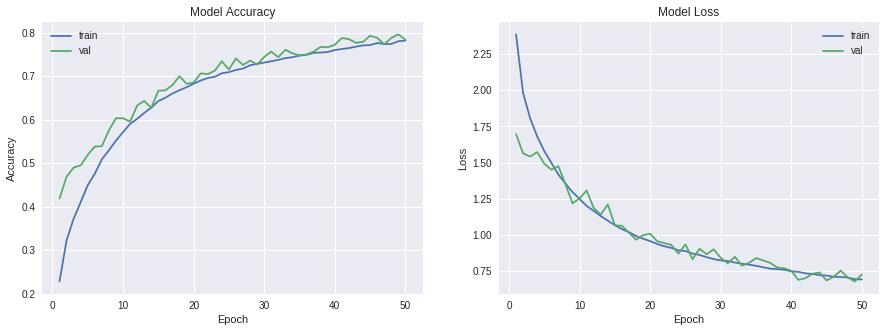

Model took 3058.28 seconds to train
Loss on test data is: 0.7276354301452637
Accuracy on test data is: 78.44


In [53]:
# plot model history
plot_model_history(improved_model_history)
print ("Model took %0.2f seconds to train"%(end - start))

# compute test accuracy
score = model_improved.evaluate(x_test, cv_labels, verbose=0)
print('Loss on test data is:', score[0])
print('Accuracy on test data is:', score[1]*100)


The model is obviously better than the original architecture and is currently undertrained and can give better accuracy on validation set if we proceed with trainning for a few more epochs.

Here we can observe an interesting effect: accuracy on validation set is higher than accuracy on test set. As I found during my reserch, this is an often situation when we use dropouts. When training, a percentage (specified in dropout) of the features are set to zero. Whereas when testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies. Now I know more =)